In [1]:
#imports
import numpy as np
import torch
import torch.nn as nn
import pickle
import torchvision
from typing import Union, List, Dict, Any, cast
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import Caltech256, CIFAR10, STL10, Caltech101
from torchvision.models import VGG

from torch.nn.parameter import Parameter
from torch.autograd import Function
import torch.nn.functional as F
from matplotlib import pyplot as plt
import multiprocessing as mp


In [2]:
# group norm
def make_gn_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                if norm_layer is None:
                    raise Error("Please specify a norm layer")
                # @group if want to use this, please refer to the higher order function
                # in the next block
                layers += [conv2d, norm_layer(v//2, v)(), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_gn_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_gn_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_gn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_gn_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [3]:
# channel batch
def make_bc_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = WConv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                num_groups = v//2
                eps=1e-08
                layers += [conv2d, BCNorm(v, num_groups, eps), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_bc_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_bc_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_bcwn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_bc_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [4]:
# channel batch
def make_bn_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                eps=1e-08
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_bn_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_bn_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11_bn(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_bn_vgg('vgg11_bn', 'A', True, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)



In [5]:
# channel batch
def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False, norm_layer = None) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            # v is the output channel
            if batch_norm:
                # @group if want to use this, please refer to the higher order function
                # in the next block
                # hyperparameters
                raise NotImplemented
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def make_vgg(arch: str, cfg: str, batch_norm: bool, pretrained: bool, progress: bool, norm_layer=None, num_classes = None, **kwargs: Any) -> VGG:
    cfgs: Dict[str, List[Union[str, int]]] = {
        'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
        'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    }
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm, norm_layer=norm_layer), num_classes = num_classes, **kwargs)
    if pretrained:
        raise NotImplementedError()
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11(pretrained: bool = False, progress: bool = True, norm_layer = None, num_classes = None, **kwargs: Any) -> VGG:
    r"""
    Makes the group norm version of VGG11
    VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_.
    The required minimum input size of the model is 32x32.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    assert num_classes is not None, "give a number of class in accordance to dataset"
    return make_vgg('vgg11', 'A', False, pretrained, progress, norm_layer = norm_layer, num_classes = num_classes, **kwargs)


In [6]:
# helper functions
def get_group_norm_layer(in_channel, out_channel):
    def fun():
        return nn.GroupNorm(in_channel, out_channel)
    return fun

# channel norm + weight
# weight
class WConv2d(nn.Conv2d):

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(WConv2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                 padding, dilation, groups, bias)

    def forward(self, x):
        weight = self.weight
        weight_mean = weight.mean(dim=1, keepdim=True).mean(dim=2,
                                  keepdim=True).mean(dim=3, keepdim=True)
        weight = weight - weight_mean
        std = torch.pow(weight.view(weight.size(0), -1).var(dim=1) + 1e-5, 0.5).view(-1, 1, 1, 1)
        weight = weight / std.expand_as(weight)
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)



class BCNorm(nn.Module):
#     eps = epsilon
    def __init__(self, num_channels, num_groups, eps, estimate=False):
        super(BCNorm, self).__init__()
        self.num_channels = num_channels
        self.num_groups = num_groups
        self.eps = eps
        self.weight = Parameter(torch.ones(1, num_groups, 1))
        self.bias = Parameter(torch.zeros(1, num_groups, 1))
        if estimate:
            self.bn = EstBN(num_channels)
        else:
            self.bn = nn.BatchNorm2d(num_channels)

    def forward(self, inp):
        out = self.bn(inp)
        out = out.view(1, inp.size(0) * self.num_groups, -1)
        out = torch.batch_norm(out, None, None, None, None, True, 0, self.eps, True)
        out = out.view(inp.size(0), self.num_groups, -1)
        out = self.weight * out + self.bias
        out = out.view_as(inp)
        return out
# batch norm


In [7]:
# dataset loading code
class GreyscaleToRGBTransform(object):    
    def __call__(self, image):  
        if image.shape[0] == 1:
            return transforms.Lambda(lambda x: x.repeat(3, 1, 1))(image)
        return image
    
def get_caltech_dataset(batch_size, val_batch_size):
    # only works with Caltech256
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((112, 112)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    # download link is broken
    dataset = Caltech256(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [24486, 6122])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle = True)
    return train_set, val_set

def get_stl_dataset(batch_size, val_batch_size):
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((96, 96)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    dataset = STL10(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [4000, 1000])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, shuffle = True)
    return train_set, val_set

def get_cifar_dataset(batch_size, val_batch_size):
    # define transforms
    train_transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         #transforms.Lambda(lambda x: x.repeat(3, 1, 1))  if x.shape[0] == 1  else NoneTransform(),                
         transforms.ToTensor(),
         #GreyscaleToRGBTransform(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    val_transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])])
    dataset = CIFAR10(root="../data", download=False, transform=train_transform)
    print(dataset)
    train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])
    train_set = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers = 4, shuffle = True)
    val_set = torch.utils.data.DataLoader(val_set, batch_size=val_batch_size, num_workers = 4, shuffle = True)
    return train_set, val_set


In [8]:
def get_model_data(num_classes):
    models = [vgg11_bcwn(num_classes = num_classes), vgg11_gn(norm_layer = get_group_norm_layer, num_classes = num_classes), vgg11_bn(num_classes = num_classes), vgg11(num_classes = num_classes)]
    model_names = ["vgg11_bcwn", "vgg11_gn", "vgg_bn", "vgg_nn"]
    return models, model_names
             
def get_dataset_data(batch_size, val_batch_size):
    datasets = [get_cifar_dataset(batch_size, val_batch_size), get_stl_dataset(batch_size, val_batch_size), get_caltech_dataset(batch_size, val_batch_size)]
    dataset_names = ["CIFAR10", "STL10", "CALTECH256"]
    num_classess = [10, 10, 257]
    return datasets[1:2], dataset_names[1:2], num_classess[1:2]


def train(args, model, device, train_loader, val_loader, optimizer, clip_grad, epoch, save_name):
    model = model.train()
    model = model.to(device)
    train_losses = []
    train_corrects = []
    train_totals = []
    train_percents = []
    val_losses = []
    val_corrects = []
    val_totals = []
    val_percents = []
    
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            target = torch.as_tensor(target) # caltech256 target is int
            data, target = data.to(device), target.to(device)        
            optimizer.zero_grad()
            output = model(data)
            #print(output.shape)
            #print(target.shape)
            loss = torch.nn.CrossEntropyLoss()(output, target)
            loss.backward()
            if clip_grad:
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            optimizer.step()
            train_losses.append(loss.item())
            _, train_preds = torch.max(output, 1)
            train_correct = torch.sum(train_preds == target)
            train_total = target.shape[0]
            train_percent = train_correct/train_total
            train_corrects.append(train_correct)
            train_totals.append(train_total)
            train_percents.append(train_percent)
            if batch_idx % args["log_interval"] == 0:
                val_loss, val_correct, val_total =  eval(model, device, val_loader, 4)
                model = model.train()
                optimizer.zero_grad()
                val_losses.append(val_loss)
                val_corrects.append(val_correct)
                val_totals.append(val_total)
                val_percents.append(val_correct/val_total)
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\Train_percent: {:.6f}\t ValLoss: {:.6f}, Valpercent: {:.6f}'.format(
                    e, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item(), train_percent, val_loss.item(), val_correct/val_total))
                if args["dry_run"]:
                    break
        #cache model
        path = "{}_{}.p".format(save_name, e)
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            "loss": train_losses,
            "val_loss": val_losses,
            "train_correct": train_corrects,
            "val_correct": val_corrects,
            "train_total": train_totals,
            "val_total": val_totals,
            "train_percent": train_percents,
            "val_percent": val_percents
            }, path)
        print("saved model state and loss to {}".format(path))

def eval(model, device, val_loader, max_eval):
    model = model.eval()
    model = model.to(device)
    val_losses = []
    val_correct = 0
    val_total = 0
    for batch_idx, (data, target) in enumerate(val_loader):
        target = torch.as_tensor(target)
        data, target = data.to(device), target.to(device)        
        output = model(data)
        loss = torch.nn.CrossEntropyLoss()(output, target)
        val_losses.append(loss.item())
        _, val_preds = torch.max(output, 1)
        val_correct += torch.sum(val_preds == target)
        val_total += target.shape[0]
        if max_eval is not None and batch_idx >= max_eval:
            break
    return np.mean(val_losses), val_correct, val_total


In [9]:
def run_tests(args):
    device = torch.device(args["device"])
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        models, model_names = get_model_data(num_classes)
        for model, mn in zip(models, model_names):
            if mn == "vgg_nn":
                clip_grad = True
            else:
                clip_grad = False
            optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
            name = "{}_{}".format(mn, dn)
            trained_model = train(args, model, args["device"], train_set, val_set, optimizer, clip_grad, args["epoch"], name)

def _test_parallel(args, model, mn, dn, train_set, val_set):
    optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
    if mn == "vgg_nn":
        clip_grad = True
    else:
        clip_grad = False
    name = "{}_{}".format(mn, dn)
    print("training model {} with {}".format(mn, dn))
    trained_model = train(args, model, args["device"], train_set, val_set, optimizer, clip_grad, args["epoch"], name)
    return name

def _run_test_parallel(args):
    return _test_parallel(*args)

def run_tests_parallel(args):
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        parallel_args = []
        models, model_names = get_model_data(num_classes)
        pool = mp.Pool(4)
        i = 1
        for model, mn in zip(models, model_names):
            args_cur = args.copy()
            args_cur["device"] = "cuda:{}".format(i)
            parallel_args.append((args_cur, model, mn, dn, train_set, val_set))
            i += 2
        print("STARTING {}".format(dn))
        results = pool.imap_unordered(_run_test_parallel, parallel_args)
        for x in results:
            print(x)        
        pool.close()
        
        pool.join()

        print("Finished {}".format(dn))
            

In [10]:
def get_args():
    args = dict()
    args["device"] = "cuda:3" 
    args["lr"] = 1e-4 # learning rate
    args["epoch"] = 10
    args["batch_size"] = 128
    args["val_batch_size"] = 128
    args["log_interval"] = 1 # 1 for stl10, 10 for other
    args["dry_run"] = False
    return args

def main():
    # in theory load from cmd, but ... jupyter
    args = get_args()
    run_tests(args)
    #run_tests_parallel(args)

In [11]:
main()

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset STL10
    Number of datapoints: 5000
    Root location: ../data
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset Caltech256
    Number of datapoints: 30608
    Root location: ../data/caltech256
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.22

/home/amrl_user/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [0/4000 (0%)]	Loss: 2.492439\Train_percent: 0.085938	 ValLoss: 3.127927, Valpercent: 0.118750
Train Epoch: 0 [128/4000 (3%)]	Loss: 3.353986\Train_percent: 0.109375	 ValLoss: 4.023688, Valpercent: 0.159375
Train Epoch: 0 [256/4000 (6%)]	Loss: 3.919311\Train_percent: 0.132812	 ValLoss: 3.924351, Valpercent: 0.090625
Train Epoch: 0 [384/4000 (9%)]	Loss: 3.891947\Train_percent: 0.093750	 ValLoss: 3.757373, Valpercent: 0.084375
Train Epoch: 0 [512/4000 (12%)]	Loss: 4.104761\Train_percent: 0.085938	 ValLoss: 3.263354, Valpercent: 0.125000
Train Epoch: 0 [640/4000 (16%)]	Loss: 3.441847\Train_percent: 0.109375	 ValLoss: 3.296599, Valpercent: 0.115625
Train Epoch: 0 [768/4000 (19%)]	Loss: 4.081455\Train_percent: 0.078125	 ValLoss: 2.388660, Valpercent: 0.145313
Train Epoch: 0 [896/4000 (22%)]	Loss: 2.734673\Train_percent: 0.101562	 ValLoss: 2.598336, Valpercent: 0.114063
Train Epoch: 0 [1024/4000 (25%)]	Loss: 2.809798\Train_percent: 0.132812	 ValLoss: 2.581347, Valpercent: 0.1500

Train Epoch: 2 [1024/4000 (25%)]	Loss: 1.621210\Train_percent: 0.312500	 ValLoss: 1.615734, Valpercent: 0.400000
Train Epoch: 2 [1152/4000 (28%)]	Loss: 1.493107\Train_percent: 0.468750	 ValLoss: 1.626365, Valpercent: 0.398438
Train Epoch: 2 [1280/4000 (31%)]	Loss: 1.675403\Train_percent: 0.335938	 ValLoss: 1.610650, Valpercent: 0.381250
Train Epoch: 2 [1408/4000 (34%)]	Loss: 1.532874\Train_percent: 0.460938	 ValLoss: 1.617098, Valpercent: 0.393750
Train Epoch: 2 [1536/4000 (38%)]	Loss: 1.598970\Train_percent: 0.367188	 ValLoss: 1.603484, Valpercent: 0.414062
Train Epoch: 2 [1664/4000 (41%)]	Loss: 1.505837\Train_percent: 0.445312	 ValLoss: 1.613789, Valpercent: 0.398438
Train Epoch: 2 [1792/4000 (44%)]	Loss: 1.582892\Train_percent: 0.382812	 ValLoss: 1.574201, Valpercent: 0.409375
Train Epoch: 2 [1920/4000 (47%)]	Loss: 1.591197\Train_percent: 0.367188	 ValLoss: 1.568331, Valpercent: 0.418750
Train Epoch: 2 [2048/4000 (50%)]	Loss: 1.529163\Train_percent: 0.429688	 ValLoss: 1.579507, Valp

Train Epoch: 4 [2048/4000 (50%)]	Loss: 1.057387\Train_percent: 0.578125	 ValLoss: 1.390894, Valpercent: 0.468750
Train Epoch: 4 [2176/4000 (53%)]	Loss: 1.077628\Train_percent: 0.546875	 ValLoss: 1.330169, Valpercent: 0.495313
Train Epoch: 4 [2304/4000 (56%)]	Loss: 0.984685\Train_percent: 0.625000	 ValLoss: 1.348007, Valpercent: 0.495313
Train Epoch: 4 [2432/4000 (59%)]	Loss: 1.028749\Train_percent: 0.640625	 ValLoss: 1.362623, Valpercent: 0.496875
Train Epoch: 4 [2560/4000 (62%)]	Loss: 1.120301\Train_percent: 0.609375	 ValLoss: 1.324471, Valpercent: 0.532813
Train Epoch: 4 [2688/4000 (66%)]	Loss: 0.901957\Train_percent: 0.671875	 ValLoss: 1.300848, Valpercent: 0.509375
Train Epoch: 4 [2816/4000 (69%)]	Loss: 1.100826\Train_percent: 0.562500	 ValLoss: 1.417951, Valpercent: 0.481250
Train Epoch: 4 [2944/4000 (72%)]	Loss: 0.999865\Train_percent: 0.632812	 ValLoss: 1.312809, Valpercent: 0.515625
Train Epoch: 4 [3072/4000 (75%)]	Loss: 0.995041\Train_percent: 0.632812	 ValLoss: 1.321291, Valp

Train Epoch: 6 [3072/4000 (75%)]	Loss: 0.295867\Train_percent: 0.898438	 ValLoss: 1.423876, Valpercent: 0.535937
Train Epoch: 6 [3200/4000 (78%)]	Loss: 0.481285\Train_percent: 0.820312	 ValLoss: 1.312779, Valpercent: 0.567187
Train Epoch: 6 [3328/4000 (81%)]	Loss: 0.393981\Train_percent: 0.828125	 ValLoss: 1.397600, Valpercent: 0.545313
Train Epoch: 6 [3456/4000 (84%)]	Loss: 0.405831\Train_percent: 0.851562	 ValLoss: 1.356142, Valpercent: 0.535937
Train Epoch: 6 [3584/4000 (88%)]	Loss: 0.371946\Train_percent: 0.921875	 ValLoss: 1.356377, Valpercent: 0.554688
Train Epoch: 6 [3712/4000 (91%)]	Loss: 0.427298\Train_percent: 0.867188	 ValLoss: 1.379097, Valpercent: 0.539062
Train Epoch: 6 [3840/4000 (94%)]	Loss: 0.283098\Train_percent: 0.937500	 ValLoss: 1.415728, Valpercent: 0.518750
Train Epoch: 6 [992/4000 (97%)]	Loss: 0.445844\Train_percent: 0.781250	 ValLoss: 1.427431, Valpercent: 0.518750
saved model state and loss to vgg11_bcwn_STL10_6.p
Train Epoch: 7 [0/4000 (0%)]	Loss: 0.260791\Tr

saved model state and loss to vgg11_bcwn_STL10_8.p
Train Epoch: 9 [0/4000 (0%)]	Loss: 0.038799\Train_percent: 0.992188	 ValLoss: 1.737360, Valpercent: 0.531250
Train Epoch: 9 [128/4000 (3%)]	Loss: 0.061953\Train_percent: 0.984375	 ValLoss: 1.745175, Valpercent: 0.532813
Train Epoch: 9 [256/4000 (6%)]	Loss: 0.046228\Train_percent: 0.992188	 ValLoss: 1.646764, Valpercent: 0.539062
Train Epoch: 9 [384/4000 (9%)]	Loss: 0.042002\Train_percent: 0.992188	 ValLoss: 1.646638, Valpercent: 0.540625
Train Epoch: 9 [512/4000 (12%)]	Loss: 0.041500\Train_percent: 0.992188	 ValLoss: 1.625214, Valpercent: 0.537500
Train Epoch: 9 [640/4000 (16%)]	Loss: 0.026357\Train_percent: 1.000000	 ValLoss: 1.522710, Valpercent: 0.551562
Train Epoch: 9 [768/4000 (19%)]	Loss: 0.036427\Train_percent: 0.992188	 ValLoss: 1.502235, Valpercent: 0.565625
Train Epoch: 9 [896/4000 (22%)]	Loss: 0.029106\Train_percent: 1.000000	 ValLoss: 1.583417, Valpercent: 0.534375
Train Epoch: 9 [1024/4000 (25%)]	Loss: 0.023674\Train_perce

Train Epoch: 1 [1024/4000 (25%)]	Loss: 2.048547\Train_percent: 0.250000	 ValLoss: 1.986437, Valpercent: 0.248438
Train Epoch: 1 [1152/4000 (28%)]	Loss: 2.002947\Train_percent: 0.234375	 ValLoss: 1.978995, Valpercent: 0.254688
Train Epoch: 1 [1280/4000 (31%)]	Loss: 2.047160\Train_percent: 0.218750	 ValLoss: 1.978835, Valpercent: 0.262500
Train Epoch: 1 [1408/4000 (34%)]	Loss: 2.047290\Train_percent: 0.218750	 ValLoss: 1.966507, Valpercent: 0.270313
Train Epoch: 1 [1536/4000 (38%)]	Loss: 2.035464\Train_percent: 0.250000	 ValLoss: 1.933536, Valpercent: 0.254688
Train Epoch: 1 [1664/4000 (41%)]	Loss: 1.994276\Train_percent: 0.250000	 ValLoss: 1.949622, Valpercent: 0.265625
Train Epoch: 1 [1792/4000 (44%)]	Loss: 2.069837\Train_percent: 0.179688	 ValLoss: 1.962435, Valpercent: 0.207813
Train Epoch: 1 [1920/4000 (47%)]	Loss: 2.025861\Train_percent: 0.164062	 ValLoss: 1.947382, Valpercent: 0.206250
Train Epoch: 1 [2048/4000 (50%)]	Loss: 2.076242\Train_percent: 0.203125	 ValLoss: 1.961258, Valp

Train Epoch: 3 [2048/4000 (50%)]	Loss: 1.713161\Train_percent: 0.359375	 ValLoss: 1.619240, Valpercent: 0.370313
Train Epoch: 3 [2176/4000 (53%)]	Loss: 1.562241\Train_percent: 0.359375	 ValLoss: 1.647989, Valpercent: 0.351562
Train Epoch: 3 [2304/4000 (56%)]	Loss: 1.620076\Train_percent: 0.343750	 ValLoss: 1.635380, Valpercent: 0.360938
Train Epoch: 3 [2432/4000 (59%)]	Loss: 1.605632\Train_percent: 0.382812	 ValLoss: 1.567338, Valpercent: 0.417188
Train Epoch: 3 [2560/4000 (62%)]	Loss: 1.569564\Train_percent: 0.390625	 ValLoss: 1.616088, Valpercent: 0.379688
Train Epoch: 3 [2688/4000 (66%)]	Loss: 1.746481\Train_percent: 0.390625	 ValLoss: 1.617745, Valpercent: 0.379688
Train Epoch: 3 [2816/4000 (69%)]	Loss: 1.552067\Train_percent: 0.351562	 ValLoss: 1.548321, Valpercent: 0.381250
Train Epoch: 3 [2944/4000 (72%)]	Loss: 1.615828\Train_percent: 0.429688	 ValLoss: 1.553718, Valpercent: 0.406250
Train Epoch: 3 [3072/4000 (75%)]	Loss: 1.452112\Train_percent: 0.484375	 ValLoss: 1.586517, Valp

Train Epoch: 5 [3072/4000 (75%)]	Loss: 1.327909\Train_percent: 0.476562	 ValLoss: 1.430772, Valpercent: 0.492188
Train Epoch: 5 [3200/4000 (78%)]	Loss: 1.367746\Train_percent: 0.460938	 ValLoss: 1.409336, Valpercent: 0.478125
Train Epoch: 5 [3328/4000 (81%)]	Loss: 1.382432\Train_percent: 0.429688	 ValLoss: 1.433004, Valpercent: 0.470313
Train Epoch: 5 [3456/4000 (84%)]	Loss: 1.216017\Train_percent: 0.578125	 ValLoss: 1.420334, Valpercent: 0.467187
Train Epoch: 5 [3584/4000 (88%)]	Loss: 1.254249\Train_percent: 0.507812	 ValLoss: 1.424428, Valpercent: 0.462500
Train Epoch: 5 [3712/4000 (91%)]	Loss: 1.358517\Train_percent: 0.429688	 ValLoss: 1.406281, Valpercent: 0.479688
Train Epoch: 5 [3840/4000 (94%)]	Loss: 1.372040\Train_percent: 0.460938	 ValLoss: 1.368396, Valpercent: 0.479688
Train Epoch: 5 [992/4000 (97%)]	Loss: 1.271008\Train_percent: 0.562500	 ValLoss: 1.483890, Valpercent: 0.407813
saved model state and loss to vgg11_gn_STL10_5.p
Train Epoch: 6 [0/4000 (0%)]	Loss: 1.135792\Trai

saved model state and loss to vgg11_gn_STL10_7.p
Train Epoch: 8 [0/4000 (0%)]	Loss: 1.015640\Train_percent: 0.648438	 ValLoss: 1.311891, Valpercent: 0.518750
Train Epoch: 8 [128/4000 (3%)]	Loss: 1.190281\Train_percent: 0.515625	 ValLoss: 1.354476, Valpercent: 0.501563
Train Epoch: 8 [256/4000 (6%)]	Loss: 1.201195\Train_percent: 0.554688	 ValLoss: 1.338376, Valpercent: 0.518750
Train Epoch: 8 [384/4000 (9%)]	Loss: 1.194994\Train_percent: 0.531250	 ValLoss: 1.285746, Valpercent: 0.535937
Train Epoch: 8 [512/4000 (12%)]	Loss: 1.032487\Train_percent: 0.632812	 ValLoss: 1.302343, Valpercent: 0.503125
Train Epoch: 8 [640/4000 (16%)]	Loss: 1.013063\Train_percent: 0.601562	 ValLoss: 1.331419, Valpercent: 0.489063
Train Epoch: 8 [768/4000 (19%)]	Loss: 1.156222\Train_percent: 0.546875	 ValLoss: 1.315862, Valpercent: 0.498437
Train Epoch: 8 [896/4000 (22%)]	Loss: 0.861262\Train_percent: 0.656250	 ValLoss: 1.366476, Valpercent: 0.500000
Train Epoch: 8 [1024/4000 (25%)]	Loss: 0.972889\Train_percent

Train Epoch: 0 [1024/4000 (25%)]	Loss: 2.748477\Train_percent: 0.187500	 ValLoss: 2.317895, Valpercent: 0.142188
Train Epoch: 0 [1152/4000 (28%)]	Loss: 2.706963\Train_percent: 0.164062	 ValLoss: 2.305381, Valpercent: 0.148438
Train Epoch: 0 [1280/4000 (31%)]	Loss: 2.594431\Train_percent: 0.250000	 ValLoss: 2.345779, Valpercent: 0.171875
Train Epoch: 0 [1408/4000 (34%)]	Loss: 2.622869\Train_percent: 0.164062	 ValLoss: 2.375762, Valpercent: 0.162500
Train Epoch: 0 [1536/4000 (38%)]	Loss: 2.347283\Train_percent: 0.195312	 ValLoss: 2.360919, Valpercent: 0.162500
Train Epoch: 0 [1664/4000 (41%)]	Loss: 2.250569\Train_percent: 0.234375	 ValLoss: 2.363115, Valpercent: 0.148438
Train Epoch: 0 [1792/4000 (44%)]	Loss: 2.103695\Train_percent: 0.226562	 ValLoss: 2.284025, Valpercent: 0.162500
Train Epoch: 0 [1920/4000 (47%)]	Loss: 2.123157\Train_percent: 0.187500	 ValLoss: 2.280610, Valpercent: 0.184375
Train Epoch: 0 [2048/4000 (50%)]	Loss: 2.224578\Train_percent: 0.187500	 ValLoss: 2.259320, Valp

Train Epoch: 2 [2048/4000 (50%)]	Loss: 1.520567\Train_percent: 0.421875	 ValLoss: 1.487139, Valpercent: 0.407813
Train Epoch: 2 [2176/4000 (53%)]	Loss: 1.400608\Train_percent: 0.445312	 ValLoss: 1.491787, Valpercent: 0.420312
Train Epoch: 2 [2304/4000 (56%)]	Loss: 1.512508\Train_percent: 0.429688	 ValLoss: 1.575512, Valpercent: 0.371875
Train Epoch: 2 [2432/4000 (59%)]	Loss: 1.429208\Train_percent: 0.468750	 ValLoss: 1.582261, Valpercent: 0.379688
Train Epoch: 2 [2560/4000 (62%)]	Loss: 1.608616\Train_percent: 0.351562	 ValLoss: 1.588574, Valpercent: 0.390625
Train Epoch: 2 [2688/4000 (66%)]	Loss: 1.565410\Train_percent: 0.359375	 ValLoss: 1.552086, Valpercent: 0.407813
Train Epoch: 2 [2816/4000 (69%)]	Loss: 1.523844\Train_percent: 0.421875	 ValLoss: 1.504378, Valpercent: 0.437500
Train Epoch: 2 [2944/4000 (72%)]	Loss: 1.383847\Train_percent: 0.429688	 ValLoss: 1.501808, Valpercent: 0.425000
Train Epoch: 2 [3072/4000 (75%)]	Loss: 1.384205\Train_percent: 0.507812	 ValLoss: 1.471023, Valp

Train Epoch: 4 [3072/4000 (75%)]	Loss: 1.357952\Train_percent: 0.468750	 ValLoss: 1.353697, Valpercent: 0.482812
Train Epoch: 4 [3200/4000 (78%)]	Loss: 1.222140\Train_percent: 0.515625	 ValLoss: 1.319312, Valpercent: 0.485938
Train Epoch: 4 [3328/4000 (81%)]	Loss: 1.149126\Train_percent: 0.593750	 ValLoss: 1.326714, Valpercent: 0.501563
Train Epoch: 4 [3456/4000 (84%)]	Loss: 1.197333\Train_percent: 0.546875	 ValLoss: 1.301087, Valpercent: 0.510938
Train Epoch: 4 [3584/4000 (88%)]	Loss: 1.209461\Train_percent: 0.531250	 ValLoss: 1.447227, Valpercent: 0.484375
Train Epoch: 4 [3712/4000 (91%)]	Loss: 1.110756\Train_percent: 0.546875	 ValLoss: 1.432939, Valpercent: 0.467187
Train Epoch: 4 [3840/4000 (94%)]	Loss: 1.214981\Train_percent: 0.523438	 ValLoss: 1.490973, Valpercent: 0.450000
Train Epoch: 4 [992/4000 (97%)]	Loss: 1.416754\Train_percent: 0.468750	 ValLoss: 1.517512, Valpercent: 0.437500
saved model state and loss to vgg_bn_STL10_4.p
Train Epoch: 5 [0/4000 (0%)]	Loss: 1.028514\Train_

saved model state and loss to vgg_bn_STL10_6.p
Train Epoch: 7 [0/4000 (0%)]	Loss: 0.751097\Train_percent: 0.726562	 ValLoss: 1.546830, Valpercent: 0.531250
Train Epoch: 7 [128/4000 (3%)]	Loss: 0.894494\Train_percent: 0.656250	 ValLoss: 1.226194, Valpercent: 0.596875
Train Epoch: 7 [256/4000 (6%)]	Loss: 0.730278\Train_percent: 0.710938	 ValLoss: 1.316569, Valpercent: 0.556250
Train Epoch: 7 [384/4000 (9%)]	Loss: 0.548432\Train_percent: 0.773438	 ValLoss: 1.455225, Valpercent: 0.529688
Train Epoch: 7 [512/4000 (12%)]	Loss: 0.765917\Train_percent: 0.750000	 ValLoss: 1.550578, Valpercent: 0.515625
Train Epoch: 7 [640/4000 (16%)]	Loss: 0.742875\Train_percent: 0.742188	 ValLoss: 1.478379, Valpercent: 0.546875
Train Epoch: 7 [768/4000 (19%)]	Loss: 0.822156\Train_percent: 0.695312	 ValLoss: 1.256376, Valpercent: 0.568750
Train Epoch: 7 [896/4000 (22%)]	Loss: 0.823273\Train_percent: 0.703125	 ValLoss: 1.206555, Valpercent: 0.575000
Train Epoch: 7 [1024/4000 (25%)]	Loss: 0.659678\Train_percent: 

Train Epoch: 9 [1024/4000 (25%)]	Loss: 0.577325\Train_percent: 0.773438	 ValLoss: 1.354091, Valpercent: 0.573438
Train Epoch: 9 [1152/4000 (28%)]	Loss: 0.520680\Train_percent: 0.804688	 ValLoss: 1.368273, Valpercent: 0.546875
Train Epoch: 9 [1280/4000 (31%)]	Loss: 0.396262\Train_percent: 0.859375	 ValLoss: 1.387329, Valpercent: 0.553125
Train Epoch: 9 [1408/4000 (34%)]	Loss: 0.616043\Train_percent: 0.804688	 ValLoss: 1.352092, Valpercent: 0.571875
Train Epoch: 9 [1536/4000 (38%)]	Loss: 0.610663\Train_percent: 0.781250	 ValLoss: 1.720612, Valpercent: 0.503125
Train Epoch: 9 [1664/4000 (41%)]	Loss: 0.435434\Train_percent: 0.843750	 ValLoss: 1.905415, Valpercent: 0.482812
Train Epoch: 9 [1792/4000 (44%)]	Loss: 0.504474\Train_percent: 0.843750	 ValLoss: 1.899132, Valpercent: 0.460938
Train Epoch: 9 [1920/4000 (47%)]	Loss: 0.495046\Train_percent: 0.859375	 ValLoss: 1.508751, Valpercent: 0.542188
Train Epoch: 9 [2048/4000 (50%)]	Loss: 0.387228\Train_percent: 0.859375	 ValLoss: 1.471550, Valp

Train Epoch: 1 [2048/4000 (50%)]	Loss: 1.742833\Train_percent: 0.281250	 ValLoss: 1.846283, Valpercent: 0.304688
Train Epoch: 1 [2176/4000 (53%)]	Loss: 1.797145\Train_percent: 0.328125	 ValLoss: 1.808628, Valpercent: 0.296875
Train Epoch: 1 [2304/4000 (56%)]	Loss: 1.808692\Train_percent: 0.242188	 ValLoss: 1.903450, Valpercent: 0.254688
Train Epoch: 1 [2432/4000 (59%)]	Loss: 1.744349\Train_percent: 0.320312	 ValLoss: 1.836926, Valpercent: 0.265625
Train Epoch: 1 [2560/4000 (62%)]	Loss: 1.860120\Train_percent: 0.242188	 ValLoss: 1.766252, Valpercent: 0.282813
Train Epoch: 1 [2688/4000 (66%)]	Loss: 1.829147\Train_percent: 0.234375	 ValLoss: 1.753293, Valpercent: 0.321875
Train Epoch: 1 [2816/4000 (69%)]	Loss: 1.724868\Train_percent: 0.296875	 ValLoss: 1.816192, Valpercent: 0.265625
Train Epoch: 1 [2944/4000 (72%)]	Loss: 1.922308\Train_percent: 0.195312	 ValLoss: 1.793028, Valpercent: 0.275000
Train Epoch: 1 [3072/4000 (75%)]	Loss: 1.794553\Train_percent: 0.304688	 ValLoss: 1.785998, Valp

Train Epoch: 3 [3072/4000 (75%)]	Loss: 1.563762\Train_percent: 0.382812	 ValLoss: 1.581669, Valpercent: 0.389062
Train Epoch: 3 [3200/4000 (78%)]	Loss: 1.596453\Train_percent: 0.328125	 ValLoss: 1.620871, Valpercent: 0.390625
Train Epoch: 3 [3328/4000 (81%)]	Loss: 1.545587\Train_percent: 0.343750	 ValLoss: 1.617330, Valpercent: 0.406250
Train Epoch: 3 [3456/4000 (84%)]	Loss: 1.567420\Train_percent: 0.390625	 ValLoss: 1.547694, Valpercent: 0.421875
Train Epoch: 3 [3584/4000 (88%)]	Loss: 1.588770\Train_percent: 0.421875	 ValLoss: 1.551897, Valpercent: 0.398438
Train Epoch: 3 [3712/4000 (91%)]	Loss: 1.469303\Train_percent: 0.460938	 ValLoss: 1.574138, Valpercent: 0.400000
Train Epoch: 3 [3840/4000 (94%)]	Loss: 1.400048\Train_percent: 0.445312	 ValLoss: 1.496413, Valpercent: 0.415625
Train Epoch: 3 [992/4000 (97%)]	Loss: 1.699492\Train_percent: 0.281250	 ValLoss: 1.580237, Valpercent: 0.389062
saved model state and loss to vgg_nn_STL10_3.p
Train Epoch: 4 [0/4000 (0%)]	Loss: 1.390854\Train_

saved model state and loss to vgg_nn_STL10_5.p
Train Epoch: 6 [0/4000 (0%)]	Loss: 1.474699\Train_percent: 0.421875	 ValLoss: 1.461185, Valpercent: 0.476562
Train Epoch: 6 [128/4000 (3%)]	Loss: 1.389394\Train_percent: 0.484375	 ValLoss: 1.380049, Valpercent: 0.484375
Train Epoch: 6 [256/4000 (6%)]	Loss: 1.501398\Train_percent: 0.421875	 ValLoss: 1.346526, Valpercent: 0.475000
Train Epoch: 6 [384/4000 (9%)]	Loss: 1.185613\Train_percent: 0.609375	 ValLoss: 1.408635, Valpercent: 0.487500
Train Epoch: 6 [512/4000 (12%)]	Loss: 1.350566\Train_percent: 0.468750	 ValLoss: 1.481672, Valpercent: 0.464063
Train Epoch: 6 [640/4000 (16%)]	Loss: 1.278656\Train_percent: 0.531250	 ValLoss: 1.432508, Valpercent: 0.473438
Train Epoch: 6 [768/4000 (19%)]	Loss: 1.343747\Train_percent: 0.460938	 ValLoss: 1.453879, Valpercent: 0.445312
Train Epoch: 6 [896/4000 (22%)]	Loss: 1.443236\Train_percent: 0.453125	 ValLoss: 1.455371, Valpercent: 0.446875
Train Epoch: 6 [1024/4000 (25%)]	Loss: 1.350843\Train_percent: 

Train Epoch: 8 [1024/4000 (25%)]	Loss: 1.137076\Train_percent: 0.578125	 ValLoss: 1.286522, Valpercent: 0.525000
Train Epoch: 8 [1152/4000 (28%)]	Loss: 1.091161\Train_percent: 0.585938	 ValLoss: 1.285891, Valpercent: 0.517188
Train Epoch: 8 [1280/4000 (31%)]	Loss: 1.094374\Train_percent: 0.617188	 ValLoss: 1.297863, Valpercent: 0.520312
Train Epoch: 8 [1408/4000 (34%)]	Loss: 1.192867\Train_percent: 0.554688	 ValLoss: 1.312916, Valpercent: 0.521875
Train Epoch: 8 [1536/4000 (38%)]	Loss: 1.088331\Train_percent: 0.554688	 ValLoss: 1.233156, Valpercent: 0.553125
Train Epoch: 8 [1664/4000 (41%)]	Loss: 1.033402\Train_percent: 0.632812	 ValLoss: 1.219663, Valpercent: 0.556250
Train Epoch: 8 [1792/4000 (44%)]	Loss: 1.025467\Train_percent: 0.625000	 ValLoss: 1.258296, Valpercent: 0.529688
Train Epoch: 8 [1920/4000 (47%)]	Loss: 1.053317\Train_percent: 0.601562	 ValLoss: 1.240897, Valpercent: 0.531250
Train Epoch: 8 [2048/4000 (50%)]	Loss: 0.976668\Train_percent: 0.617188	 ValLoss: 1.285098, Valp

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset STL10
    Number of datapoints: 5000
    Root location: ../data
    Split: train
    StandardTransform
Transform: Compose(
               Resize(size=(96, 96), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Dataset Caltech256
    Number of datapoints: 30608
    Root location: ../data/caltech256
    StandardTransform
Transform: Compose(
               Resize(size=(112, 112), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.22

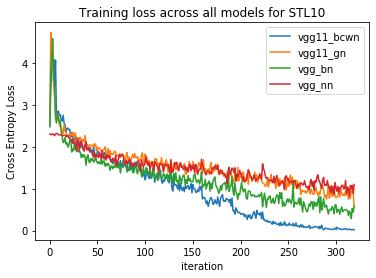

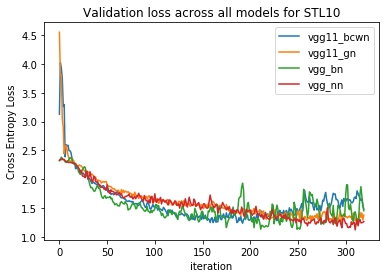

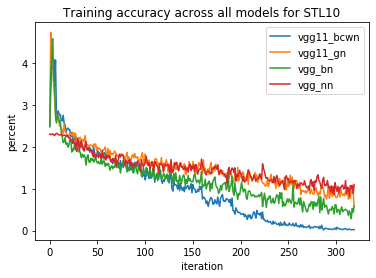

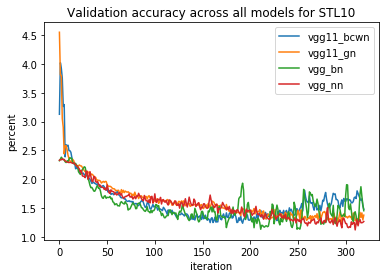

In [12]:
# plotting code
def plot_losses(dn, mnlosses, title):
    plt.figure()
    for mn, loss in mnlosses:
        plt.plot(loss, label=mn)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("Cross Entropy Loss")
    plt.title(title)
    plt.savefig("../figure/{}.png".format(title))

def plot_accuracy(dn, mnpercents, title):
    plt.figure()
    for mn, accuracy in mnpercents:
        plt.plot(accuracy, label=mn)
    plt.legend()
    plt.xlabel("iteration")
    plt.ylabel("percent")
    plt.title(title)
    plt.savefig("../figure/{}.png".format(title))
    
def plot_all(args, MAX_EPOCH):
    device = torch.device(args["device"])
    datasets, dataset_names, num_classess = get_dataset_data(args["batch_size"], args["val_batch_size"])
    cache_data = dict()
    for num_classes, dn, (train_set, val_set) in zip(num_classess, dataset_names, datasets):
        models, model_names = get_model_data(num_classes)
        for model, mn in zip(models, model_names):
            if mn == "vgg_nn":
                clip_grad = True
            else:
                clip_grad = False
            optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
            checkpt_name = "{}_{}_{}.p".format(mn, dn, MAX_EPOCH)
            checkpoint = torch.load(checkpt_name)
            model.load_state_dict(checkpoint['model'])
            cache_data[(dn, mn)] = checkpoint
            #plot_train_loss(mn, dn, train_losses)
            #return
    # plot the training loss
    for dn in dataset_names:
        mntlosses = [(mn, cache_data[(dn, mn)]["loss"]) for mn in model_names]
        mnvlosses = [(mn, cache_data[(dn, mn)]["val_loss"]) for mn in model_names]
        mntaccuracy = [(mn, cache_data[(dn, mn)]["train_percent"]) for mn in model_names]
        mnvaccuracy = [(mn, cache_data[(dn, mn)]["val_percent"]) for mn in model_names]
        
        plot_losses(dn, mntlosses, "Training loss across all models for {}".format(dn))
        plot_losses(dn, mnvlosses, "Validation loss across all models for {}".format(dn))
        plot_accuracy(dn, mntlosses, "Training accuracy across all models for {}".format(dn))
        plot_accuracy(dn, mnvlosses, "Validation accuracy across all models for {}".format(dn))
        
    plt.show()
    
plot_all(get_args(), 9)